# Imports and packages

In [26]:
## Basic Packages

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import random
import re
import string
import os
from datetime import datetime
from random import sample

## nltk imports
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

In [27]:
## spacy imports
import spacy
import en_core_web_sm
sp = spacy.load('en_core_web_sm')
nlp = en_core_web_sm.load()

In [28]:
## vectorizer
from sklearn.feature_extraction.text import CountVectorizer
## sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [29]:
## lda
import gensim
from gensim import corpora

In [30]:
## repeated printouts and wide-format text
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_colwidth', None)

# Text analysis of Department of Justice (DOJ) press releases

- For background:

    - DOJ is the federal law enforcement agency responsible for federal prosecutions; this contrasts with the local prosecutions in the Cook County dataset we analyzed earlier. Here's a short explainer on which crimes get prosecuted federally versus locally: https://www.criminaldefenselawyer.com/resources/criminal-defense/federal-crime/state-vs-federal-crimes.htm#:~:text=Federal%20criminal%20prosecutions%20are%20handled,of%20state%20and%20local%20law. 
    - Here's the Kaggle that contains the data: https://www.kaggle.com/jbencina/department-of-justice-20092018-press-releases 
    - Here's the code the dataset creator used to scrape those press releases here if you're interested: https://github.com/jbencina/dojreleases
    
- See here for a codebook: https://docs.google.com/spreadsheets/d/1UopmSvFGrwJvz_c3Plh32Yxkqwff64oS_CcpfATOV8k/edit?usp=sharing

In [31]:
## Unzipping JSON file:

# Creating directories
filename = os.getcwd() + "\\combined.json.zip"
extract_dir = os.getcwd() + "\\unzipped"

# Making older if it doesn't exist:
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Extracting:
import shutil
shutil.unpack_archive(filename, extract_dir)

In [32]:
# Reading in JSON file:
extract = extract_dir + "\\combined.json"
doj = pd.read_json(extract, lines = True)

# ## Due to json, topics are in a list so remove them and concatenate with ;
doj['topics_clean'] = ["; ".join(topic) if len(topic) > 0 else "No topic" for topic in doj.topics]

# ## similarly with components
doj['components_clean'] = ["; ".join(comp) if len(comp) > 0 else "No component" for comp in doj.components]

# ## drop older columns from data
doj = doj[['id', 'title', 'contents', 'date', 'topics_clean', 'components_clean']].copy()

doj.head()

id  \
0     None   
1  12-919    
2  11-1002   
3   10-015   
4   18-898   

                                                                                                          title  \
0                                                                  Convicted Bomb Plotter Sentenced to 30 Years   
1                              $1 Million in Restitution Payments Announced to Preserve North Carolina Wetlands   
2                 $1 Million Settlement Reached for Natural Resource Damages at Superfund Site in Massachusetts   
3                                          10 Las Vegas Men Indicted \r\nfor Falsifying Vehicle Emissions Tests   
4  $100 Million Settlement Will Speed Cleanup Work at Centredale Manor Superfund Site in North Providence, R.I.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

## Tagging and sentiment scoring

Focusing on the following press release: `id` == "17-1204" about this pharmaceutical kickback prosecution: https://www.forbes.com/sites/michelatindera/2017/11/16/fentanyl-billionaire-john-kapoor-to-plead-not-guilty-in-opioid-kickback-case/?sh=21b8574d6c6c 

The `contents` column is the one we're treating as a document. 

We'll call the raw string of this press release `pharma`

In [33]:
pharma = str(doj["contents"][doj.id == "17-1204"])


A. Preprocessing the `pharma` press release to remove all punctuation / digits (so can use `.isalpha()` to subset)

B. With the preprocessed press release from part A, using the part of speech tagger within nltk to tag all the words in that one press release with their part of speech. 

C. Using the output from B, extracting the adjectives and sort those adjectives from most occurrences to fewest occurrences. Print a dataframe with the 5 most frequent adjectives and their counts in the `pharma` release. See here for a list of the names of adjectives within nltk: https://pythonprogramming.net/natural-language-toolkit-nltk-part-speech-tagging/

In [34]:
# Tokenizing data: 
pharma_tokens = word_tokenize(pharma)
print(pharma_tokens[:10])
pharma_alpha = [word for word in pharma_tokens if word.isalpha()]
print(pharma_alpha[:10])

['4909', 'The', 'founder', 'and', 'majority', 'owner', 'of', 'Insys', 'Therapeutics', 'Inc.']
['The', 'founder', 'and', 'majority', 'owner', 'of', 'Insys', 'Therapeutics', 'was', 'arrested']


<Font Color = 'Blue'>

'4909' and "Inc." are both removed. Is that what we want?

</FONT>

In [35]:
# Speech tagging
pharma_tagged = pos_tag(pharma_alpha)
print("First 10 elements of adjectives in pharma:")
print(pharma_tagged[0:10])

# Extracting adjectives:
    # JJ adjective 'big'
    # JJR adjective, comparative 'bigger'
    # JJS adjective, superlative 'biggest'
pharma_adj = [tup[0] for tup in pharma_tagged if tup[1] in ["JJ", "JJR", "JJS"]]

## Counting occurances:
# Initializing empty dict:
# freq = {}
# # Doing for loop to fill dictionary:
# for adj in pharma_adj:
#     if adj in freq.keys():
#         freq[adj] += 1
#     else:
#         freq[adj] = 1

# Using already created module:
from collections import Counter
freq_2 = Counter(pharma_adj)

# Getting 5 most common adjectives:
print("\n \n Five most common adjectives in pharma & their counts:")
freq_2.most_common(5)

First 10 elements of adjectives in pharma:
[('The', 'DT'), ('founder', 'NN'), ('and', 'CC'), ('majority', 'NN'), ('owner', 'NN'), ('of', 'IN'), ('Insys', 'NNP'), ('Therapeutics', 'NNP'), ('was', 'VBD'), ('arrested', 'VBN')]

 
 Five most common adjectives in pharma & their counts:


[('former', 8),
 ('opioid', 5),
 ('nationwide', 4),
 ('other', 3),
 ('addictive', 3)]

## Named entity recognition

A. Using the original `pharma` press release (so the one before stripping punctuation/digits), using spaCy to extract all named entities from the press release.

B. Printing the unique named entities with the tag: `LAW`. Here's some background on what RICO means: https://www.justia.com/criminal/docs/rico/ 

In [36]:
# Converting to sp:
sp_pharma = sp(pharma)

# Extracting names entities:
sp_pharma_ent = sp_pharma.ents

# Extracting law-tagged entities:
pharma_ent_law = [one_ents.text for one_ents in sp_pharma_ent if one_ents.label_ == "LAW"] 

# Printing unique entries:
set(pharma_ent_law)

{'RICO', 'the Controlled Substances Act'}

Extracting the possible sentence lengths the CEO is facing; pull out the named entities with (1) the label `DATE` and (2) that contain the word year or years. Print these named entities.

In [37]:
# Pulling named entities with label == DATE
pharma_ent_sent = [one_ents.text for one_ents in sp_pharma_ent if one_ents.label_ == "DATE"]

# Pulling named entities that contain the word year/years
pharma_ent_sent = [one_ents for one_ents in pharma_ent_sent if re.search(r"(year|years)", one_ents) != None]

# Printing:
pharma_ent_sent

['last year', 'three years', 'three years']

D. Parsing the pharma string at the sentence level. Note that this involves more than just splitting on each `.`

Then, using those sentences, pulling and printing the original sentences from the press releases where those year lengths are mentioned.

In [38]:
# Converting to string: 
sp_pharma = str(sp_pharma)

## Parsing sentences based on periods (.) , quotation marks (") & this weird thing (\xa0)
# Not on commas because then it also removes 20,000 and things like xyz, smt, lmn 
pharma_sents = re.findall(r'(.*?)(\.|\"|\xa0\s)', sp_pharma)

# Selecting appropriate length & with year in it 
year_sents = [sents[0] for sents in pharma_sents if (len(sents[0]) > 1) & (re.search(r"(year|years)", sents[0]) != None)]

# Printing the results
year_sents

['More than 20,000 Americans died of synthetic opioid overdoses last year, and millions are addicted to opioids',
 'The charges of conspiracy to commit RICO and conspiracy to commit mail and wire fraud each provide for a sentence of no greater than 20 years in prison, three years of supervised release and a fine of $250,000, or twice the amount of pecuniary gain or loss',
 'The charges of conspiracy to violate the Anti-Kickback Law provide for a sentence of no greater than five years in prison, three years of supervised release and a $25,000 fine']

## Sentiment analysis  

Subseting the press releases to those labeled with one of three topics via `topics_clean`: Civil Rights, Hate Crimes, and Project Safe Childhood. 


In [39]:
doj_subset = doj[doj["topics_clean"].isin(["Civil Rights", "Hate Crimes", "Project Safe Childhood"])]
print("Shape of resulting dataset: " + str(doj_subset.shape))

Shape of resulting dataset: (717, 6)



B. Writing a function that takes one press release string as an input and:

- Removes named entities from each press release string 
- Scores the sentiment of the entire press release using the `SentimentIntensityAnalyzer` and `polarity_scores`
- Returns the length-four (negative, positive, neutral, compound) sentiment dictionary (any order is fine)

Appling that function to each of the press releases in `doj_subset`. 

In [40]:
## Defining Function

def one_3b(raw):
    
    # Getting named eintities:
    raw_nlp = nlp(raw)
    
    # Initializing empty list for named eintities:
    list_ne = []
    
    # Adding all names entities into list:
    for one_ents in raw_nlp.ents:
        list_ne.append(one_ents.text)
        
    # Making a regex pattern of these named entities we will substitute with "":
    # The comma is optional replacement because otherwise "Evans, 43," would be " , , " instead of ""
    raw2 = re.sub(("(,)?|").join([re.escape(strng) for strng in list_ne]), "", raw)
        
    # Initializing a scorer
    sent_obj = SentimentIntensityAnalyzer()
    
    # Scoring sentiment:
    sentiment_example = sent_obj.polarity_scores(raw2)
    
    # Adding contents:
    sentiment_example["contents"] = raw
    
    return(sentiment_example)

# Applying Function:
print("Starting ftn: " + str(pd.Timestamp.now()))
rez = [one_3b(raw) for raw in doj_subset["contents"]]
print("Ending ftn: " + str(pd.Timestamp.now()))

Starting ftn: 2022-11-05 12:01:29.829491
Ending ftn: 2022-11-05 12:02:24.342720


Adding the four sentiment scores to the `doj_subset` dataframe to create a dataframe: `doj_subset_wscore`. Sort from highest neg to lowest neg score (so most negative to least negative) and print the `id`, `contents`, and `neg` columns of the two most negative press releases. 

In [41]:
# Converting results of list comprehension to dataframe: 
rez_df = pd.DataFrame(rez)

# Copying the original dataset
doj_subset_wscore = doj_subset

# Merging sentiments & original data
doj_subset_wscore = doj_scored.merge(rez_df, left_on = "contents", right_on = "contents")

# Sorting, according to least neagtive values:
doj_subset_wscore = doj_scored.sort_values("neg", ascending = False)

# Showing top two contents:
doj_subset_wscore.head(n=2)

,id,title,contents,date,topics_clean,components_clean,neg,neu,pos,compound
13,14-248,Albuquerque Man Charged with Federal Hate Crime Related to Anti-Semitic Threats Against Businesswoman,"The Department of Justice announced that this morning John W. Ng, 58, of Albuquerque, N.M., made his initial appearance in federal court on a criminal complaint charging him with a hate crime offense. This charge is related to anti-Semitic threats Ng made against a Jewish woman who owns and operates the Nosh Jewish Delicatessen and Bakery in Albuquerque. Ng was arrested by the FBI on March 7, 2014, based on a criminal complaint alleging that he interfered with the victim’s federally protected rights by threatening her and interfering with her business because of her religion. According to the criminal complaint, between Jan. 22, 2014, and Feb. 8, 2014, Ng allegedly posted threatening anti-Semitic notes on and in the vicinity of the victim’s business. A criminal complaint merely establishes probable cause, and Ng is presumed innocent unless proven guilty. If convicted on the offense charged in the criminal complaint, Ng faces a maximum statutory penalty of one year in prison. This matter was investigated by the Albuquerque Division of the FBI and is being prosecuted by Assistant U.S. Attorney Mark T. Baker of the U.S. Attorney’s Office for the District of New Mexico and Trial Attorney AeJean Cha of the U.S. Department of Justice’s Civil Rights Division.",2014-03-10T00:00:00-04:00,Hate Crimes,Civil Rights Division; Civil Rights - Criminal Section,0.327,0.634,0.039,-0.9950
34,13-312,Aryan Brother Inmate Sentenced for Federal Hate Crime for Assaulting Fellow Inmate,"John Hall, 27, an Aryan Brotherhood member and inmate at the Federal Correctional Institution (FCI) in Seagoville, Texas, was sentenced today by U.S. District Judge Reed O’Connor after pleading guilty to violating the Matthew Shepard and James Byrd Jr. Hate Crimes Prevention Act stemming from his assault of a fellow inmate, whom he believed to be gay, the Department of Justice announced. Hall assaulted his fellow inmate with a dangerous weapon, causing bodily injury to the victim on Dec. 20, 2011. Hall was sentenced to serve 71 months in prison to be served consecutively with the sentence he is currently serving. The assault occurred on Dec. 20, 2011, inside the FCI Seagoville when Hall targeted and attacked the victim, a fellow inmate, because he believed the victim was gay or involved in a sexual relationship with another male inmate. Hall repeatedly punched, kicked and stomped on the victim’s face with his shod feet, a dangerous weapon, while yelling a homophobic slur. The victim lost consciousness during the assault and suffered multiple lacerations to his face. The victim also sustained a fractured eye socket, lost a tooth, fractured other teeth and was treated at a hospital for the injuries he sustained during Hall’s unprovoked attack. Hall pleaded guilty to violating the Matthew Shepard and James Byrd Jr. Hate Crimes Prevention Act on Nov. 8, 2012. “Brutality and violence based on sexual orientation has no place in a civilized society,” said Thomas E. Perez, Assistant Attorney General for the Civil Rights Division. “The Justice Department is committed to using all the tools in our law enforcement arsenal, including the Matthew Shepard and James Byrd Jr. Hate Crimes Prevention Act, to prosecute acts motivated by hate.” “This prosecution sends a clear message that this office, in partnership with attorneys in the department’s Civil Rights Division, will prioritize and aggressively prosecute hate crimes and others civil rights violations in North Texas,” said U.S. Attorney Sarah R. Saldaña of the Northern District of Texas. This case was investigated by the FBI Dallas Division. The case was prosecuted by Assistant U.S. Attorney Errin Martin and Trial Attorney Adriana Vieco of the Civil Rights Division.",2013-03-14T00:00:00-04:00,Hate Crimes,Civil Rights Division; Civil Rights - Cr

With the dataframe, finding the mean compound sentiment score for each of the three topics in `topics_clean` using group_by and agg.

In [46]:
## agg and find the mean compound score by topic
doj_subset_wscore.groupby("topics_clean").agg({"compound" : "mean"}).reset_index().sort_values(by = "compound")

,topics_clean,compound
1,Hate Crimes,-0.934505
2,Project Safe Childhood,-0.649320
0,Civil Rights,-0.097169


<div class="alert alert-block alert-success">

<b>Interpretation:<br> </b>
    <br>
Press releases related to <b> hate crimes would naturally be the most negative </b> because of the words usually associated with such crimes and because people would generally strong words to describe them in press releases. <br>
    <br>
Similarly, we would see strong words and emotions used for projects related to safe childhood. <br>
    <br>
As important as civil rights are to regular citizens, I would imagine press releases related to civil rights would be worded less strongly than the other two; more to temper emotions of audience than to flare them.
   
</div>

# Topic modeling 

For this question, use the `doj_subset_wscores` data that is restricted to civil rights, hate crimes, and project safe childhood and with the sentiment scores added


## 2.1 Preprocess the data by removing stopwords, punctuation, and non-alpha words (5 points)

### Part A:

A. Write a function that:

- Takes in a single raw string in the `contents` column from that dataframe
- Does the following preprocessing steps:

    - Converts the words to lowercase
    - Removes stopwords, adding the custom stopwords in the code cell below to the default stopwords list
    - Only retains alpha words (so removes digits and punctuation)
    - Only retains words 4 characters or longer
    - Uses the snowball stemmer from nltk to stem

- Returns a joined preprocessed string (so if press release is something like "The CEO was indicted" it might return "ceo indict" 

In [47]:
# Pre-required material:
# Stopwords:
list_stopwords = stopwords.words("english")
custom_doj_stopwords = ["civil", "rights", "division", "department", "justice",
                        "office", "attorney", "district", "case", "investigation", "assistant",
                       "trial", "assistance", "assist"]
comp_stopwords = list_stopwords + custom_doj_stopwords

In [48]:
# Defining fntn for list comprehension:
def comp_processing_lc(raw):
    
    ## initialize stemmer
    snow = SnowballStemmer("english")
    
    # 1. Converting to lower case:
    raw_lower = raw.lower()
    
    # 2. Tokeninzing words:
    raw_tokens = word_tokenize(raw_lower)
    
    # 3. Removing stopwords:
    raw_nostop = [snow.stem(word) for word in raw_tokens if word not in comp_stopwords
                  and word.isalpha()
                  and len(word) >= 4]
    
    raw_final = (" ".join(raw_nostop))
    
    return(raw_final)
    
# comp_processing("The CEO was indicted")

### Part B:
B. Use `apply` or list comprehension to execute that function and create a new column in the data called `processed_text`. Note: there will be a deduction if your code uses a non-list comprehension for loop that uses append.

In [50]:
# doj_subset_wscores["processed_text"] = doj_subset_wscores.apply(comp_processing, axis = 1)
doj_subset_wscore["processed_text"] = [comp_processing_lc(wn) for wn in doj_subset_wscore["contents"]]

### Part C:

C. Print the `id`, `contents`, and `processed_text` columns for the following press releases:

id = 16-718 (this case: https://www.seattletimes.com/nation-world/doj-miami-police-reach-settlement-in-civil-rights-case/)

id = 16-217 (this case: https://www.wlbt.com/story/32275512/three-mississippi-correctional-officers-indicted-for-inmate-assault-and-cover-up/)

In [51]:
doj_subset_wscore[["id", "contents", "processed_text"]][(doj_subset_wscore["id"] == "16-718") | (doj_subset_wscore["id"] == "16-217")]

,id,contents,processed_text
632,16-718,"In a nine-count indictment unsealed today, two Mississippi correctional officers were charged with beating an inmate and a third was charged with helping to cover it up. The indictment charged Lawardrick Marsher, 28, and Robert Sturdivant, 47, officers at Mississippi State Penitentiary, in Parchman, Mississippi, with a beating that included kicking, punching and throwing the victim to the ground. Marsher and Sturdivant were charged with violating the right of K.H., a convicted prisoner, to be free from cruel and unusual punishment. Sturdivant was also charged with failing to intervene while Marsher was punching and beating K.H. The indictment alleges that their actions involved the use of a dangerous weapon and resulted in bodily injury to the victim. A third officer, Deonte Pate, 23, was charged along with Marsher and Sturdivant for conspiring to cover up the beating. The indictment alleges that all three officers submitted false reports and that all three lied to the FBI. If convicted, Marsher and Sturdivant face a maximum sentence of 10 years in prison on the excessive force charges. Each of the three officers faces up to five years in prison on the conspiracy and false statement charges, and up to 20 years in prison on the false report charges. An indictment is merely an accusation, and the defendants are presumed innocent unless and until proven guilty. This case is being investigated by the FBI’s Jackson Division, with the cooperation of the Mississippi Department of Corrections. It is being prosecuted by Assistant U.S. Attorney Robert Coleman of the Northern District of Mississippi and Trial Attorney Dana Mulhauser of the Civil Rights Division’s Criminal Section. Marsher Indictment",indict unseal today mississippi correct offic charg beat inmat third charg help cover indict charg lawardrick marsher robert sturdiv offic mississippi state penitentiari parchman mississippi beat includ kick punch throw victim ground marsher sturdiv charg violat right convict prison free cruel unusu punish sturdiv also charg fail interven marsher punch beat indict alleg action involv danger weapon result bodili injuri victim third offic deont pate charg along marsher sturdiv conspir cover beat indict alleg three offic submit fals report three lie convict marsher sturdiv face maximum sentenc year prison excess forc charg three offic face five year prison conspiraci fals statement charg year prison fals report charg indict mere accus defend presum innoc unless proven guilti investig jackson cooper mississippi correct prosecut robert coleman northern mississippi dana mulhaus crimin section marsher indict
313,16-217,"The Justice Department has reached a comprehensive settlement agreement with the city of Miami and the Miami Police Department (MPD) resolving the Justice Department’s investigation of officer-involved shootings by MPD officers, announced Principal Deputy Assistant Attorney General Vanita Gupta, head of the Justice Department’s Civil Rights Division and U.S. Attorney Wifredo A. Ferrer of the Southern District of Florida. The settlement, which was approved by Miami’s city commission today and will go into effect when the agreement is signed by all parties, resolves claims stemming from the Justice Department’s investigation into officer-involved shootings by MPD officers, which was conducted under the Violent Crime Control and Law Enforcement Act of 1994. The investigation’s findings, issued in July 2013, identified a pattern or practice of excessive use of force through officer-involved shootings in violation of the Fourth Amendment of the Constitution. The city’s compliance with the settlement will be monitored by an independent reviewer, former Tampa, Florida, Police Chief Jane Castor. Under the settlement agreement, the city will implement comprehensive reforms to ensure constitutional policing and support public trust. The settlement agreement is designed to minimize officer-involved shoot

**Resources**:

- Here's code examples for the snowball stemmer: https://www.geeksforgeeks.org/snowball-stemmer-nlp/
- Here's code with topic modeling steps: 
https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/09_textasdata_partII_topicmodeling_solution.ipynb

## 2.2 Create a document-term matrix from the preprocessed press releases and to explore top words (5 points)

### Part A:

A. Use the `create_dtm` function I provide (alternately, feel free to write your own!) and create a document-term matrix using the preprocessed press releases; make sure metadata contains the following columns: `id`, `compound` sentiment column you added, and the `topics_clean` column

In [52]:
def create_dtm(list_of_strings, metadata):
    vectorizer = CountVectorizer(lowercase = True)
    dtm_sparse = vectorizer.fit_transform(list_of_strings)
    dtm_dense_named = pd.DataFrame(dtm_sparse.todense(), 
        columns=vectorizer.get_feature_names())
    dtm_dense_named_withid = pd.concat([metadata.reset_index(), dtm_dense_named], axis = 1)
    return(dtm_dense_named_withid)

In [53]:
dtm_subset_wscores = create_dtm(list_of_strings= doj_subset_wscore.processed_text,
                metadata = doj_subset_wscore[['id', 'compound', 'topics_clean']])
dtm_subset_wscores

,index,id,compound,topics_clean,aaron,abandon,abbat,abbi,abbott,abdomen,...,zamora,zane,zealand,zealous,zeeman,zero,zobel,zone,zunggeemog,zwengel
0,13,14-248,-0.9950,Hate Crimes,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,34,13-312,-0.9983,Hate Crimes,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,632,16-718,-0.9964,Civil Rights,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,22,11-626,-0.9986,Hate Crimes,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,564,11-1531,-0.9968,Hate Crimes,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,581,15-667,0.7003,Civil Rights,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
713,392,16-539,0.9854,Civil Rights,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
714,346,17-003,0.9766,Civil Rights,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
715,324,17-132,0.9812,Civil Rights,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Part B, C & D: 
B. Print the top 10 words for press releases with compound sentiment in the top 5% (so the most positive sentiment)

C. Print the top 10 words for press releases with compound sentiment in the bottom 5% (so the most negative sentiment)

**Hint**: for these, remember the pandas quantile function from pset two.  

D. Print the top 10 words for press releases in each of the three `topics_clean`

For steps B - D, to receive full credit, write a function `get_topwords` that helps you avoid duplicated code when you find top words for the different subsets of the data. There are different ways to structure it but one way is to feed it subsetted data (so data subsetted to one topic etc.) and for it to get the top words for that subset.

**Resources**:

- Here contains an example of applying the create_dtm function: 
https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/09_textasdata_partII_topicmodeling_solution.ipynb


In [85]:
## Making a function, that takes in the DTM that needs to be processed as an argument:
def get_topwords(dtm_needed):
    
    # 1. List of top words found by summing columns; excluding index, ID, compound (sentiment score) & topics_clean columns
    top_words = dtm_needed[[col for col in dtm_needed.columns if re.search(r"(index|id|compound|topics_clean)", col) == None]].sum(axis = 0)
    
    # 2. Sorting words
    top_words = top_words.sort_values(ascending = False)
    
    # 3. Returning a list of top_words in that particular dataset
    return(top_words)

## Part B: Press releases with compound sentiment in the top 5% (so the most positive sentiment)

# Getting appropriate dataset with most positive sentiments: 
top_5 = doj_subset_wscore[doj_subset_wscore.compound >= doj_subset_wscore.compound.quantile(0.95)]

# Creating DTM:
dtm_top5 = create_dtm(list_of_strings= top_5.processed_text,
                        metadata = top_5[['id', 'compound', 'topics_clean']])
    
# Applying fntn for topwords and getting top 10 values:
print("Most Common Words for sentiments in the top 5%: ")
get_topwords(dtm_top5).head(n=10)

Most Common Words for sentiments in the top 5%: 


agreement    171
state        119
enforc       116
ensur        105
disabl       102
student       86
servic        86
court         85
general       82
communiti     81
dtype: int64

In [86]:
## Part C: Press releases with compound sentiment in the least 5% (so the most negative sentiment)
# Getting appropriate dataset with most positive sentiments: 
bottom_5 = doj_subset_wscore[doj_subset_wscore.compound >= doj_subset_wscore.compound.quantile(0.05)]

# Creating DTM:
dtm_bottom5 = create_dtm(list_of_strings= bottom_5.processed_text,
                        metadata = bottom_5[['id', 'compound', 'topics_clean']])
    
# Applying fntn for topwords and getting top 10 values:
print("Most Common Words for sentiments in the top 5%: ")
get_topwords(dtm_bottom5).head(n=10)

Most Common Words for sentiments in the top 5%: 


child       1075
feder       1073
victim       991
prosecut     950
sentenc      902
state        871
charg        842
general      817
today        812
enforc       784
dtype: int64

In [87]:
## Part D: Press releases for all 3 topics:
for topic in ("Civil Rights", "Hate Crimes", "Project Safe Childhood"):
    
    topic_df = doj_subset_wscore[doj_subset_wscore.topics_clean == topic]
    
    topic_dtm = create_dtm(list_of_strings= topic_df.processed_text,
                        metadata = topic_df[['id', 'compound', 'topics_clean']])
    
    print("Top 15 words in " + topic + " press releases are: ")
    
    get_topwords(topic_dtm).head(n=15)

Top 15 words in Civil Rights press releases are: 


offic        627
hous         620
discrimin    541
enforc       531
disabl       509
feder        475
violat       470
state        443
general      408
agreement    407
alleg        405
court        398
today        388
polic        339
requir       324
dtype: int64

Top 15 words in Hate Crimes press releases are: 


victim      590
crime       533
prosecut    476
hate        472
defend      459
sentenc     455
charg       452
guilti      430
feder       426
indict      332
year        326
today       323
prison      314
investig    314
assault     291
dtype: int64

Top 15 words in Project Safe Childhood press releases are: 


child          1018
exploit         698
sexual          570
safe            476
project         472
childhood       472
pornographi     447
children        416
crimin          404
prosecut        374
sentenc         354
victim          338
ceo             317
minor           300
abus            283
dtype: int64

## 2.3 Estimate a topic model using those preprocessed words (5 points)

A. Going back to the preprocessed words from part 2.1, estimate a topic model with 3 topics, since you want to see if the unsupervised topic models recover different themes for each of the three manually-labeled topics (civil rights; hate crimes; project safe childhood). You have free rein over the other topic model parameters beyond the number of topics.

**Hints and Resources**:

- Same topic modeling resources linked to above
- Make sure to use the `random_state` argument within the model so that the numbering of topics does not move around between runs of your code

In [57]:
## Preparing raw data:

# 1. Tokenizing words in the processed text column of scored DOJ Subset 
pr_tokens = [wordpunct_tokenize(one_text) for one_text in doj_subset_wscore.processed_text]

# 2. Using genism to create a dictionary and get all unique words across press releases 
pr_dict = corpora.Dictionary(pr_tokens)

# 3. Filtering out most rare and most common words:
lb = round(doj_subset_wscore.shape[0]*0.05)
ub = round(doj_subset_wscore.shape[0]*0.95)

# 4. Applying filters to dictionary:
pr_dict.filter_extremes(no_below = lb, no_above = ub)

# 5. Applying dictionary to tokenized PRs & getting mappings
corpus_fromdict = [pr_dict.doc2bow(one_text) for one_text in pr_tokens]

#len(corpus_fromdict) # 717 rows: consistent with 717 pr of the 3 topics
# Seeing IDs of words and counts
# id_words = [[(pr_dict[id], count) for id, count in line] for line in corpus_fromdict]
# print(id_words)

# 6. Estimating the model: 
doj_ldamod = gensim.models.ldamodel.LdaModel(
    corpus_fromdict, # Corpus of dictionary we just made
    num_topics = 3, 
    id2word= pr_dict, # Dictionary of words and their IDs
    per_word_topics = True, 
    random_state = 91988)

### Part B:


B. After estimating the topic model, print the top 15 words in each topic.

In [58]:
# The Regex extraction is for personal practise. 
for i in range(3):
    print("Top 15 words for topic number " + str(i) + ":")
    string = doj_ldamod.print_topics(num_words = 15)[i][1]
    print("\n Raw version from LDA model:")
    string
    print("Extracted/Cleaned list of top 15 words & associated probabilities:")
    wrds = re.findall(r'\"(\w*)\"', string)
    prb = re.findall(r'0\.0\d\d', string)
    dict(zip(wrds, prb))

Top 15 words for topic number 0:

 Raw version from LDA model:


'0.015*"child" + 0.013*"victim" + 0.011*"sentenc" + 0.011*"state" + 0.010*"prosecut" + 0.009*"general" + 0.009*"today" + 0.009*"guilti" + 0.009*"said" + 0.008*"exploit" + 0.008*"year" + 0.008*"crimin" + 0.008*"court" + 0.008*"act" + 0.008*"feder"'

Extracted/Cleaned list of top 15 words & associated probabilities:


{'child': '0.015',
 'victim': '0.013',
 'sentenc': '0.011',
 'state': '0.011',
 'prosecut': '0.010',
 'general': '0.009',
 'today': '0.009',
 'guilti': '0.009',
 'said': '0.009',
 'exploit': '0.008',
 'year': '0.008',
 'crimin': '0.008',
 'court': '0.008',
 'act': '0.008',
 'feder': '0.008'}

Top 15 words for topic number 1:

 Raw version from LDA model:


'0.013*"feder" + 0.010*"offic" + 0.009*"general" + 0.009*"defend" + 0.009*"sentenc" + 0.009*"said" + 0.009*"polic" + 0.008*"individu" + 0.008*"charg" + 0.008*"violat" + 0.008*"today" + 0.008*"court" + 0.008*"investig" + 0.008*"prosecut" + 0.008*"enforc"'

Extracted/Cleaned list of top 15 words & associated probabilities:


{'feder': '0.013',
 'offic': '0.010',
 'general': '0.009',
 'defend': '0.009',
 'sentenc': '0.009',
 'said': '0.009',
 'polic': '0.009',
 'individu': '0.008',
 'charg': '0.008',
 'violat': '0.008',
 'today': '0.008',
 'court': '0.008',
 'investig': '0.008',
 'prosecut': '0.008',
 'enforc': '0.008'}

Top 15 words for topic number 2:

 Raw version from LDA model:


'0.014*"victim" + 0.012*"prosecut" + 0.012*"charg" + 0.011*"feder" + 0.010*"guilti" + 0.010*"said" + 0.010*"child" + 0.010*"crime" + 0.010*"hous" + 0.010*"enforc" + 0.009*"sentenc" + 0.009*"sexual" + 0.008*"offic" + 0.008*"investig" + 0.008*"today"'

Extracted/Cleaned list of top 15 words & associated probabilities:


{'victim': '0.014',
 'prosecut': '0.012',
 'charg': '0.012',
 'feder': '0.011',
 'guilti': '0.010',
 'said': '0.010',
 'child': '0.010',
 'crime': '0.010',
 'hous': '0.010',
 'enforc': '0.010',
 'sentenc': '0.009',
 'sexual': '0.009',
 'offic': '0.008',
 'investig': '0.008',
 'today': '0.008'}

## 2.4 Add topics back to main data and explore correlation between manual labels and our estimated topics (10 points)

A. Extract the document-level topic probabilities. Within `get_document_topics`, use the argument `minimum_probability` = 0 to make sure all 3 topic probabilities are returned. Write an assert statement to make sure the length of the list is equal to the number of rows in the `doj_subset_wscores` dataframe

In [59]:
## Part A: Doc-level Probabilities 

# Creating document-level topic probabilities: 
doc_level = [doj_ldamod.get_document_topics(item, minimum_probability = 0) for item in corpus_fromdict]

# Asserting statement - returned True:
len(doc_level) == len(doj_subset_wscore.index)

True

### Part B:

B. Add the topic probabilities to the `doj_subset_wscores` dataframe as columns and create a column, `top_topic`, that reflects each document to its highest-probability topic (eg topic 1, 2, or 3)


In [60]:
## Adding probabilities to doj_subset_wscore & creating top_topic

# A "long" for dataframe by flattening the list
lng = pd.DataFrame([t for lst in doc_level for t in lst], columns = ['topic', 'probability'])

# Adding id:
lng['doc_id'] = list(np.concatenate([[one_id] * 3 for one_id in doj_subset_wscore.id]).flat)

# Pivot to wide format
wid = pd.pivot_table(lng, index = ['doc_id'], columns = ['topic']).reset_index().reset_index(drop = True)

# Renaming 
wid.columns = ['doc_id'] + ["topic_" + str(i) for i in np.arange(0, 3)]

# merging
topic_wmeta = pd.merge(wid, doj_subset_wscore, left_on = 'doc_id', right_on = 'id')

# Adding highest probability top topic column
topic_wmeta['toptopic'] = topic_wmeta[[col for col in topic_wmeta.columns if "topic_" in col]].idxmax(axis=1)

# Just making sure we're on the right track:
topic_wmeta.shape[0] == len(pd.unique(doj_subset.id))
topic_wmeta.sample(n=1)

True

,doc_id,topic_0,topic_1,topic_2,id,title,contents,date,topics_clean,components_clean,neg,neu,pos,compound,processed_text,toptopic
49,10-320,0.720613,0.270698,0.008689,10-320,"Mobile, Alabama, Man Pleads Guilty to Federal Civil Rights Charges Related to Desecration of Synagogue","WASHINGTON – Christian Rodney Ice, 19, of Mobile, Ala., pleaded guilty today in federal court in Mobile to one count of violating the Church Arson Act by placing threatening graffitti and neo-Nazi markings on a synagogue in Mobile, the Justice Department and the U.S. Attorney’s office for the Southern District of Alabama announced. Sentencing has been scheduled for Sept. 23, 2010. Ice faces a maximum prison sentence of one-year in prison and a fine of up to $100,000. During the plea proceedings and in documents filed in court, Ice admitted that during the late night and early morning hours of Jan. 3-4, 2009, he and an associate used spray paint to place anti-Semitic graffiti and neo-Nazi markings on the Congregation Tree of Life Messianic Synagogue in Mobile. The graffiti and markings included the German words ""Juden Raus"" (""Jews Out""), and the statement ""Hitler was right."" ""Threats against religious institutions and their members will not be tolerated in this country,"" said Thomas E. Perez, Assistant Attorney General for the Civil Rights Division. ""This case should send a clear message to others who would carry out similar criminal acts that they will be brought to justice and held accountable for their actions."" ""The U.S. Attorney’s Office will continue to use all the tools at its disposal to stamp out hate crimes and instances of bigotry,"" said Kenyen R. Brown, United States Attorney for the Southern District of Alabama. The case was investigated by special agents from the Mobile Division of the Federal Bureau of Investigation and the City of Mobile Police Department. The case is being prosecuted by Assistant U.S. Attorney George May of the U.S. Attorney’s Office for the Southern District of Alabama and Trial Attorney Donald Tunnage of the Civil Rights Division.",2010-03-26T00:00:00-04:00,Hate Crimes,Civil Rights Division; Civil Rights - Criminal Section,0.13,0.813,0.057,-0.9595,washington christian rodney mobil plead guilti today feder court mobil count violat church arson place threaten graffitti mark synagogu mobil southern alabama announc sentenc schedul face maximum prison sentenc prison fine plea proceed document file court admit late night earli morn hour associ use spray paint place graffiti mark congreg tree life messian synagogu mobil graffiti mark includ german word juden raus jew statement hitler right threat religi institut member toler countri said thoma perez general send clear messag other would carri similar crimin act brought held account action continu tool dispos stamp hate crime instanc bigotri said kenyen brown unit state southern alabama investig special agent mobil feder bureau citi mobil polic prosecut georg southern alabama donald tunnag,topic_0


### Part C:

C. For each of the manual labels in `topics_clean` (Hate Crime, Civil Rights, Project Safe Childhood), print the breakdown of the % of documents with each top topic (so, for instance, Hate Crime has 246 documents-- if 123 of those documents are coded to topic_1, that would be 50%; and so on). 
**Hint**:    
pd.crosstab and normalize may be helpful: https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.crosstab.html

D. Using a couple press releases as examples, write a 1-2 sentence interpretation of why some of the manual topics map on more cleanly to an estimated topic than other manual topic(s)

**Resources**:

- End of this code (`Additional summaries of topics and documents`) contains example of how to use `get_document_topics` and other steps to add topic probabilities back to data: 
https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/09_textasdata_partII_topicmodeling_solution.ipynb
- If you're getting errors, use shape, len, and other commands to check the dimensionality of things at different steps since documents may be dropped if they contain no words post-processing 

In [64]:
## your code here to summarize the topic proportions for each of the topics_clean
print("Numbers: ")
pd.crosstab(index = ([topic_wmeta["topics_clean"]]), 
            columns  = topic_wmeta["toptopic"])
print("Proportions: ")
pd.crosstab(index = ([topic_wmeta["topics_clean"]]), 
            columns  = topic_wmeta["toptopic"],
           normalize = 'all')

Numbers: 


toptopic,topic_0,topic_1,topic_2
topics_clean,,,
Civil Rights,8,229,64
Hate Crimes,116,5,125
Project Safe Childhood,159,1,0


Proportions: 


toptopic,topic_0,topic_1,topic_2
topics_clean,,,
Civil Rights,0.011315,0.323904,0.090523
Hate Crimes,0.164074,0.007072,0.176803
Project Safe Childhood,0.224894,0.001414,0.000000


In [358]:
topic_wmeta[(topic_wmeta["topic_0"] < 0.5) & (topic_wmeta["topics_clean"] == "Project Safe Childhood")].sort_values(by = 'topic_0', ascending = False)
# topic_wmeta.sort_values(by = 'topic_0', ascending = False)

,doc_id,topic_0,topic_1,topic_2,id,title,contents,date,topics_clean,components_clean,neg,neu,pos,compound,processed_text,toptopic
484,16-618,0.005893,0.989815,0.004292,16-618,"United States, Mexico and Canada Join Forces to Improve Amber Alert System","The U.S. Department of Justice’s Office of Prosecutorial Development, Assistance and Training (OPDAT) and Mexico’s Office of the Attorney General (PGR) sponsored a Trinational Forum yesterday and today in Mexico City, bringing together Amber Alert Coordinators from Mexico, the United States and Canada. The forum aimed to create mechanisms for the international coordination of Amber Alerts in order to better respond to potential cross-border cases of missing children. Opening the forum, Mexican Attorney General Arely Gomez highlighted the importance of international cooperation in the identification of missing children, noting that the Amber Alert program “breaks the barriers of communication, time and distance,” and highlighted that the “neutralization and disruption of criminal groups and their operations cannot depend on limits created by borders or national identities.” The importance of the Amber Alert system also was recognized by U.S. Attorney General Loretta E. Lynch in her remarks yesterday at the annual National Missing Children’s Day Ceremony in Washington, D.C., where she noted the Trinational Event in Mexico City and said, “and our commitment to rescuing missing children does not stop at the border. I am proud to say that our Department of Justice has collaborated with the Attorney General of Mexico on the development of Mexico’s AMBER Alert System, which has already resulted in the rescue of hundreds of Mexican children.” OPDAT Senior Resident Legal Advisor Ray Gattinella told Amber Alert coordinators in Mexico City, “we currently have 75 open abduction cases from the United States to Mexico and 183 open cases from Mexico to the United States. So it makes sense that our countries would continue the collaboration on Amber Alert we started four years ago and begin coordinating on potential cross-border and interstate missing children cases.” OPDAT assisted PGR in the creation and implementation of Amber Alert Mexico based on the U.S. program in May 2012. Since that time, Amber Alert has led to the rescue of over 350 children in Mexico. The program has also become a central piece of OPDAT’s programming in Mexico under the Merida Initiative. The United States immensely values the cooperation and collaboration from both Mexico and Canada in this critical area.",2016-05-26T00:00:00-04:00,Project Safe Childhood,Criminal Division,0.074,0.812,0.114,0.8542,prosecutori develop train opdat mexico general sponsor trinat forum yesterday today mexico citi bring togeth amber alert coordin mexico unit state canada forum aim creat mechan intern coordin amber alert order better respond potenti case miss children open forum mexican general are gomez highlight import intern cooper identif miss children note amber alert program break barrier communic time distanc highlight neutral disrupt crimin group oper depend limit creat border nation import amber alert system also recogn general loretta lynch remark yesterday annual nation miss children ceremoni washington note trinat event mexico citi said commit rescu miss children stop border proud collabor general mexico develop mexico amber alert system alreadi result rescu hundr mexican opdat senior resid legal advisor gattinella told amber alert coordin mexico citi current open abduct case unit state mexico open case mexico unit state make sens countri would continu collabor amber alert start four year begin coordin potenti interst miss children opdat assist creation implement amber alert mexico base program sinc time amber alert rescu children mexico program also becom central piec opdat program mexico merida initi unit state immens valu cooper collabor mexico canada critic area,topic_1


<div class="alert alert-block alert-success">

<b> Part D. Using a couple press releases as examples, write a 1-2 sentence interpretation of why some of the manual topics map on more cleanly to an estimated topic than other manual topic(s)<br> </b>
    <br>
<b> ID: 16-1215
    <br> Title: Colorado and Illinois Men Sentenced to Prison for Engaging in Child Exploitation Enterprise 
    <br> Top Probability: topic_0 </b> <br>
    This PR contains a lot of "child" related vocabulary, which related mostly to topic_0 -> hence, the PR is overwhelmingly topic_0. <br>
    <b><br><br> ID: 16-618 
        <br> Title: United States, Mexico and Canada Join Forces to Improve Amber Alert System
        <br>  topic_0: 0.005893 </b> <br>
    While this PR discusses Amber Alerts, it does not relate directly to child exploitation charge, which is why it isn't mapped cleanly to topic_0. 
</div>

# 3. Extend the analysis from unigrams to bigrams (9 points)

In the previous question, you found top words via a unigram representation of the text. Now, we want to see how those top words change with bigrams (pairs of words)

A. Using the `doj_subset_wscore` data and the `processed_text` column (so the words after stemming/other preprocessing), create a column in the data called `processed_text_bigrams` that combines each consecutive pairs of word into a bigram separated by an underscore. Eg:

"depart reach settlem" would become "depart_reach reach_settlem"

Do this by writing a function `create_bigram_onedoc` that takes in a single `processed_text` string and returns a string with its bigrams structured similarly to above example
 
**Hint**: there are many ways to solve but `zip` may be helpful: https://stackoverflow.com/questions/21303224/iterate-over-all-pairs-of-consecutive-items-in-a-list

B. Print the `id`, `processed_text`, and `processed_text_bigram` columns for press release with id = 16-217

In [82]:

## Creating function
def create_bigram_onedoc(raw):
    
    raw = word_tokenize(raw)
    # Initiating empty string
    bigram = ""
    
    # Making pairs, joining them and appending them to the empty string
    for first, second in zip(raw, raw[1:]):
        bigram = bigram + first + "_" + second + " "
    
    # Returning bigram
    return bigram

# Applying function
doj_subset_wscore["processed_text_bigrams"] = [create_bigram_onedoc(raw) for raw in doj_subset_wscore.processed_text]

# Subsetting:
doj_subset_wscore[["id", "processed_text","processed_text_bigrams"]][doj_subset_wscore["id"] == "16-217"]

,id,processed_text,processed_text_bigrams
313,16-217,reach comprehens settlement agreement citi miami miami polic resolv shoot offic announc princip deputi general vanita gupta head wifredo ferrer southern florida settlement approv miami citi commiss today effect agreement sign parti resolv claim stem shoot offic conduct violent crime control enforc find issu juli identifi pattern practic excess forc shoot violat fourth amend constitut citi complianc settlement monitor independ review former tampa florida polic chief jane castor settlement agreement citi implement comprehens reform ensur constitut polic support public trust settlement agreement design minim shoot effect quick investig shoot occur measur includ settlement repres renew commit citi miami chief rodolfo llane provid constitut polic miami resid protect public safeti sustain reform said princip deputi general gupta agreement help strengthen relationship communiti serv improv account offic fire weapon unlaw provid communiti particip enforc today agreement result joint effort citi miami ensur miami polic continu effort make communiti safe protect sacr constitut citizen said ferrer oversight communic agreement seek make perman posit chang former chief orosa chief llane made applaud citi commiss settlement agreement build upon import reform implement citi sinc issu find includ conduct attorney staff special litig section southern florida,reach_comprehens comprehens_settlement settlement_agreement agreement_citi citi_miami miami_miami miami_polic polic_resolv resolv_shoot shoot_offic offic_announc announc_princip princip_deputi deputi_general general_vanita vanita_gupta gupta_head head_wifredo wifredo_ferrer ferrer_southern southern_florida florida_settlement settlement_approv approv_miami miami_citi citi_commiss commiss_today today_effect effect_agreement agreement_sign sign_parti parti_resolv resolv_claim claim_stem stem_shoot shoot_offic offic_conduct conduct_violent violent_crime crime_control control_enforc enforc_find find_issu issu_juli juli_identifi identifi_pattern pattern_practic practic_excess excess_forc forc_shoot shoot_violat violat_fourth fourth_amend amend_constitut constitut_citi citi_complianc complianc_settlement settlement_monitor monitor_independ independ_review review_former former_tampa tampa_florida florida_polic polic_chief chief_jane jane_castor castor_settlement settlement_agreement agreement_citi citi_implement implement_comprehens comprehens_reform reform_ensur ensur_constitut constitut_polic polic_support support_public public_trust trust_settlement settlement_agreement agreement_design design_minim minim_shoot shoot_effect effect_quick quick_investig investig_shoot shoot_occur occur_measur measur_includ includ_settlement settlement_repres repres_renew renew_commit commit_citi citi_miami miami_chief chief_rodolfo rodolfo_llane llane_provid provid_constitut constitut_polic polic_miami miami_resid resid_protect protect_public public_safeti safeti_sustain sustain_reform reform_said said_princip princip_deputi deputi_general general_gupta gupta_agreement agreement_help help_strengthen strengthen_relationship relationship_communiti communiti_serv serv_improv improv_account account_offic offic_fire fire_weapon weapon_unlaw unlaw_provid provid_communiti communiti_particip particip_enforc enforc_today today_agreement agreement_result result_joint joint_effort effort_citi citi_miami miami_ensur ensur_miami miami_polic polic_continu continu_effort effort_make make_communiti communiti_safe safe_protect protect_sacr sacr_constitut constitut_citizen citizen_said said_ferrer ferrer_oversight oversight_communic communic_agreement agreement_seek seek_make make_perman perman_posit posit_chang chang_former former_chief chief_orosa orosa_chief chief_llane llane_made made_applaud applaud_citi citi_commiss commiss_settlement settlement_agreement agreement_build build_upon upon_import import_reform reform_implement implement_citi citi_sinc sinc_issu issu_find find

### Part C & D:

C. Use the create_dtm function and the `processed_text_bigrams` column to create a document-term matrix (`dtm_bigram`) with these bigrams. Keep the following three columns in the data: `id`, `topics_clean`, and `compound` 

D. Print the 
 (1) dimensions of the `dtm` matrix from question 2.2  and 
 (2) the dimensions of the `dtm_bigram` matrix. Comment on why the bigram matrix has more dimensions than the unigram matrix 

E. Find and print the 10 most prevelant bigrams for each of the three topics_clean using the `get_topwords` function from 2.2


In [89]:
## Parts C & D:
dtm_bigram = create_dtm(list_of_strings= doj_subset_wscore["processed_text_bigrams"],
                metadata = doj_subset_wscore[['id', 'compound', 'topics_clean']])

print("Dimensions of unigram DTM: " + str(dtm_subset_wscores.shape))
print("Dimensions of bigram DTM: " + str(dtm_bigram.shape))

Dimensions of unigram DTM: (717, 6760)
Dimensions of bigram DTM: (717, 71334)


<div class="alert alert-block alert-success">

<b>Comments for part E:<br> </b>
    <br>
    Each word would occur only once, but it can be a part of multiple pairings e.g. <b> offic </b> would only count once, but could be a part of multiple pairings e.g.:
    <br>
    offic_field<br>
    offic_pay<br>
    offic_rant<br>
    offic_merc<br>
   
</div>

In [92]:
## Part D: Press releases for all 3 topics:
for topic in ("Civil Rights", "Hate Crimes", "Project Safe Childhood"):
    
    topic_df = doj_subset_wscore[doj_subset_wscore.topics_clean == topic]
    
    topic_dtm = create_dtm(list_of_strings= topic_df.processed_text_bigrams,
                        metadata = topic_df[['id', 'compound', 'topics_clean']])
    
    print("Top 10 pairings in " + topic + " press releases are: ")
    
    get_topwords(topic_dtm).head(n=10)

Top 10 pairings in Civil Rights press releases are: 


fair_hous         227
deputi_general    221
princip_deputi    221
vanita_gupta      202
gupta_head        200
general_vanita    199
unit_state        152
nation_origin     141
consent_decre     127
announc_today     122
dtype: int64

Top 10 pairings in Hate Crimes press releases are: 


hate_crime       368
plead_guilti     275
year_prison      160
special_agent    117
thoma_perez      111
grand_juri       101
perez_general     95
unit_state        87
act_general       85
burn_cross        83
dtype: int64

Top 10 pairings in Project Safe Childhood press releases are: 


project_safe         472
safe_childhood       472
child_pornographi    445
child_exploit        279
sexual_exploit       223
exploit_children     199
plead_guilti         197
child_sexual         175
exploit_obscen       175
obscen_section       174
dtype: int64

# 4. Optional extra credit 1 (1 point)

You notice that the pharmaceutical kickbacks press release we analyzed in question 1 was for an indictment, and that in the original data, there's not a clear label for whether a press release outlines an indictment (charging someone with a crime), a conviction (convicting them after that charge either via a settlement or trial), or a sentencing (how many years of prison or supervised release a defendant is sentenced to after their conviction).

You want to see if you can identify pairs of press releases where one press release is from one stage (e.g., indictment) and another is from a different stage (e.g., a sentencing).

You decide that one way to approach is to find the pairwise string similarity between each of the processed press releases in `doj_subset`. There are many ways to do this, so Google for some approaches, focusing on ones that work well for entire documents rather than small strings.

Find the top two pairs (so four press releases total)-- do they seem like different stages of the same crime or just press releases covering similar crimes?

In [237]:
# Using cosine_similarity -> Works fast and works well for an entire document

from sklearn.metrics.pairwise import cosine_similarity
vectorizer = CountVectorizer(lowercase = True)
dtm_sparse = vectorizer.fit_transform(doj_subset.contents)
co_sin = cosine_similarity(dtm_sparse)

# Threshold for 95% similarity:
result = np.where(co_sin > 0.95)

df_final = pd.DataFrame({'focal_content': pd.Series(dtype='object'),
                         'similar_content': pd.Series(dtype='object'),
                         'similarity_ratio': pd.Series(dtype='object')
                        })

for i in range(len(result[1])):
    pos_fc = result[0][i]
    pos_nc = result[1][i]
    
    con_fc = doj_subset.iloc[pos_fc]["contents"]
    con_nc = doj_subset.iloc[pos_nc]["contents"]
    
    if con_fc != con_nc:                               # To prevent it from matching with itself
        similarity_ratio = co_sin[pos_fc][pos_nc]
        
        if con_fc not in list(df_final["similar_content"]):         # To prevent pair from occuring in vice-versa positions
            # initialize list of listsd
            data = [[con_fc, con_nc, similarity_ratio]]
            
            # Create the pandas DataFrame
            df = pd.DataFrame(data, columns=['focal_content', 'similar_content','similarity_ratio'])
            df_final = pd.concat([df_final,df])

df_final = df_final.sort_values("similarity_ratio", ascending = False)
df_final.head( n = 3)

,focal_content,similar_content,similarity_ratio
0,"A Church Hill, Maryland, resident was sentenced today to 20 years in prison to be followed by a lifetime term of supervised release for enticement of a minor to engage in sexual activity and attempting to transfer obscene materials to a minor, announced Acting Assistant Attorney General Kenneth A. Blanco of the Justice Department’s Criminal Division and Acting U.S. Attorney Benjamin G. Greenberg of the Southern District of Florida. Lee Robert Moore, 38, pleaded guilty March 1, 2017, before U.S. District Judge Daniel T. K. Hurley of the Southern District of Florida. Moore was employed by the U.S. Secret Service-Uniformed Division and was assigned to the White House at the time of his arrest on Nov. 9, 2015, and has remained in custody since that time. Moore has since been terminated from his Secret Service position. According to admissions made in connection with his plea, Moore maintained a profile on the social media application “Meet24,” which provides a mobile-based platform for exchanging digital images, as well as voice and text messages. Delaware State Police Detectives with the Delaware Child Predator Task Force created a profile on this site, posing as a 14-year-old girl, with whom Moore engaged in a number of online chat sessions, via the “Meet24” and “Kik” mobile apps over a two-month period, including while Moore was at work. A number of the online chats between Moore and the undercover officers posing as a female minor were sexual in nature and, on several occasions, Moore sent pictures of himself, including one sexually explicit image. According to the plea documents, after his arrest, law enforcement discovered that Moore had communicated with a minor in Florida. Moore admitted that in those communications, he sent sexually explicit images of himself and enticed the minor to send sexually explicit photos of herself as well. Moore engaged in the same type of behavior with a 14-year-old girl in Texas and another 17-year-old girl in Missouri. Moore requested that his federal charges in Delaware be transferred to the Southern District of Florida so that he could plead guilty to both charges at one time. U.S. Immigration and Customs Enforcement’s Homeland Security Investigations and the Delaware Child Predator Task Force investigated the case. Trial Attorney Austin M. Berry of the Criminal Division’s Child Exploitation and Obscenity Section (CEOS) and Assistant U.S. Attorney Corey Steinberg of the Southern District of Florida prosecuted the case, with assistance from the U.S. Attorney’s Office for the District of Delaware. This case was brought as part of Project Safe Childhood, a nationwide initiative to combat the growing epidemic of child sexual exploitation and abuse, launched in May 2006 by the Department of Justice. Led by U.S. Attorneys’ Offices and CEOS, Project Safe Childhood marshals federal, state and local resources to better locate, apprehend and prosecute individuals who exploit children via the Internet, as well as to identify and rescue victims. For more information about Project Safe Childhood, please visit http://www.justice.gov/psc.","A Church Hill, Maryland resident pleaded guilty today in federal court to one count of enticement of a minor to engage in sexual activity and one count of attempting to transfer obscene materials to a minor, announced Acting Assistant Attorney General Kenneth A. Blanco of the Justice Department’s Criminal Division and U.S. Attorney Wifredo A. Ferrer of the Southern District of Florida. Lee Robert Moore, 38, pleaded guilty today before U.S. District Judge Daniel T. K. Hurley of the Southern District of Florida. Moore was employed by the U.S. Secret Service-Uniformed Division and was assigned to the White House at the time of his arrest on Nov. 9, 2015, and has remained in custody since that time. Moore has since been terminated from his Secret Service position. According to admissions made in connection with his plea, M

<div class="alert alert-block alert-danger"> 
Note: The scraping kept getting times out so this data is very much tainted and biased as more recent years are included.
</div>

In [345]:
doj = pd.read_json("combined_4.json", lines = True)
doj['topics_clean'] = ["; ".join(topic) if len(topic) > 0 else "No topic" for topic in doj.topics]
doj['components_clean'] = ["; ".join(comp) if len(comp) > 0 else "No component" for comp in doj.components]
doj = doj[['id', 'title', 'contents', 'date', 'topics_clean', 'components_clean']].copy()

for js_fl in ("combined_5_20.json", "combined21_120.json", "combined121_300.json"):
    print("File being loaded: "+ js_fl)
    print("Original doj length: " + str(len(doj.index)))
    doj_2 = pd.read_json( js_fl , lines = True)
    doj_2['topics_clean'] = ["; ".join(topic) if len(topic) > 0 else "No topic" for topic in doj_2.topics]
    doj_2['components_clean'] = ["; ".join(comp) if len(comp) > 0 else "No component" for comp in doj_2.components]
    doj_2 = doj_2[['id', 'title', 'contents', 'date', 'topics_clean', 'components_clean']].copy()
    doj = pd.concat([doj, doj_2])
    print("Concatenated doj length: " + str(len(doj.index)))


# len(doj_2.index)
# 
# len(doj.index)
# pd.unique(doj.date)

File being loaded: combined_5_20.json
Original doj length: 5167
Concatenated doj length: 10334
File being loaded: combined21_120.json
Original doj length: 10334
Concatenated doj length: 15501
File being loaded: combined121_300.json
Original doj length: 15501
Concatenated doj length: 20668


In [346]:
len(doj.index)
doj = doj.drop_duplicates()
len(doj.index)

20668

5167

In [335]:
trump = doj[(doj["date"] > "2016-01-01T00:00:00-00:00'") & (doj["date"] < "2020-01-01T00:00:00-00:00'")]
biden = doj[(doj["date"] > "2020-01-01T00:00:00-00:00'")]

In [338]:
### Plotting Change in themes:

# Creating Data:
trump_themes = trump.topics_clean.value_counts().reset_index()
trump_themes = trump_themes[trump_themes["index"] != "No topic"]
trump_themes = trump_themes.head(n = 10)

biden_themes = biden.topics_clean.value_counts().reset_index()
biden_themes = biden_themes[biden_themes["index"] != "No topic"]
biden_themes = biden_themes.head(n = 10)
biden_themes["grph"] = biden_themes["topics_clean"]*(-1)

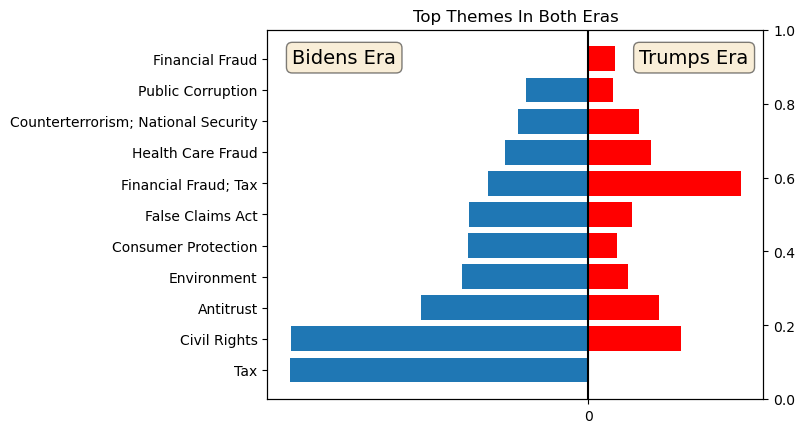

In [339]:
# Plotting:
import matplotlib.pyplot as plt

# # Creating plot:
fig, ax = plt.subplots(sharey=True);

ax1 = plt.barh(biden_themes["index"], biden_themes["grph"], fill = "Blue")
ax2 = plt.barh(trump_themes["index"], trump_themes["topics_clean"], color = "Red")
ax.twinx()
plt.axvline(x="0", color = 'black')
ax.set_title("Top Themes In Both Eras")

textstr1 = "Bidens Era"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr1, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

textstr2 = "Trumps Era"
ax.text(0.75, 0.95, textstr2, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


for s in ['top', 'bottom', 'right', "left"]: ax.spines[s].set_visible(True);

plt.show();